In [1]:
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import psutil
import math
import seaborn as sns
from datetime import timedelta, datetime, tzinfo, timezone, time
from PIL import Image, ImageDraw
from numpy import asarray
from math import atan2,degrees,radians
from scipy.spatial import distance
import sys

## *Introduction:* 

This data contains children's drawings (each child drew about 22 drawings).<br>
Each drawing has a CSV file and an image of the drawing that also contains the original drawing that the child was asked to draw. 

We had to perform the following four tasks (per drawing):

1. Count the number of hand lifts.
2. Count the amount of lines.
3. Measure the length and the average pressure applied to each line.
4. Determine whether a shape is open or closed (only in specific shape).

<br><br>

This function is preparing the data for comfortable us,
for example:<br>

* Check that the file number is valid (less than 22, notice that image number 22 exists but there is no CSV file)
* Check if the csv file is empty (exists, but contains only a headers).
* Remove extra spaces from column names.
* Change column type.
* Remove extra rows at the end of the file.

In [2]:
def dataPreprocessin(folder,csvNum):
    if(csvNum >= 22):
        return print("file isn't exist") #file number 22 does not exist (there is only an empty image) we will ignore this file.
    url = (r'train/'+str(folder)+'/SimpleTest/'+str(csvNum)+'.csv')
    data = pd.read_csv(url)
    if (len(data) <= 2): #check if the file is empty
        return print("CSV file is empty")
    else:
        data.columns = data.columns.str.replace(' ', '')
        data.dropna(inplace=True)
        data['X'] = data.X.astype(float)
        data.Time = data.Time.str.replace("00:","").astype(np.float64)
        return data

In [3]:
data = pd.read_csv(r'train/7554/SimpleTest/5.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          505 non-null    object 
 1    Y         503 non-null    float64
 2    Pressure  503 non-null    float64
 3    TiltX     503 non-null    float64
 4    TiltY     503 non-null    float64
 5    Time      503 non-null    object 
dtypes: float64(4), object(2)
memory usage: 23.8+ KB


In [5]:
#remove the extra spaces in the columns.
print(data.columns)
data.columns = data.columns.str.replace(' ', '')
data.head(3)

Index(['X', ' Y', ' Pressure', ' TiltX', ' TiltY', ' Time'], dtype='object')


,X,Y,Pressure,TiltX,TiltY,Time
0,608.351079801363,833.323017,0.107164,-3848.0,-644.0,00:02.7272871
1,608.877699503407,833.165031,0.107164,-3848.0,-644.0,00:02.7429109
2,608.877699503407,833.165031,0.099107,-3848.0,-644.0,00:02.7585749


In [6]:
submit_time = data.iloc[-1][0]
start_time = data.iloc[-2][0]
data.dropna(inplace=True)
print(start_time)
print(submit_time)

total_time = float(submit_time[37:]) - float(start_time[38:])
print("Total time drawing: 00:" +str(total_time))

Time Elapsed till drawing started: 00:02.7272871
Time Elapsed till drawing submit: 00:18.2575765
Total time drawing: 00:15.5302894


In [7]:
data['X'] = data.X.astype(float)

# change the Time column to float
data.Time = data.Time.str.replace("00:","").astype(np.float64)

```python
# other way to deal with the Time column
data.Time = data.Time.apply(lambda x: datetime.strptime(x[:-1],"%M:%S.%f"))
```

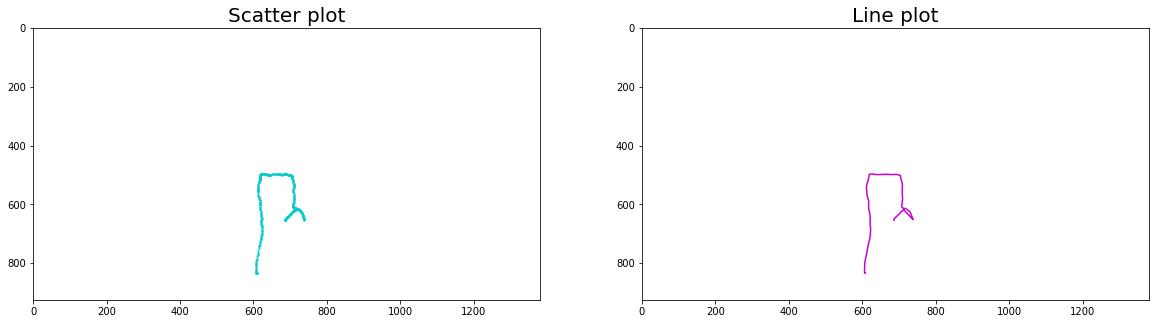

In [8]:
fig=plt.figure(figsize=(20,5))
ax= fig.add_subplot(1, 2, 1)

plt.gca().invert_yaxis()
ax.scatter(data.X,data.Y,s=1,c='#00CCCC')
ax.set_xbound(lower=0.0, upper=1381)
ax.set_ybound(lower=0.0, upper=925)
ax.set_title("Scatter plot",fontdict={'fontsize': 20})

ax2 = fig.add_subplot(1, 2, 2)
plt.gca().invert_yaxis()
ax2.plot(data.X,data.Y,"#CC00CC")
ax2.set_xbound(lower=0.0, upper=1381)
ax2.set_ybound(lower=0.0, upper=925)
ax2.set_title("Line plot",fontdict={'fontsize': 20})

plt.show()

In [10]:
def LiveDarwing(data):
    %matplotlib notebook

    fig = plt.figure(figsize=(5,3) ,dpi=100)
    ax = fig.add_subplot(1,1,1)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    X=[]
    Y=[]
    for i in range (len(data.X)):
        X.append(data.X[i])
        Y.append(data.Y[i])
        plt.tight_layout()
        ax.plot(X,Y , color='r')
        fig.canvas.draw() 
plt.close()

<IPython.core.display.Javascript object>


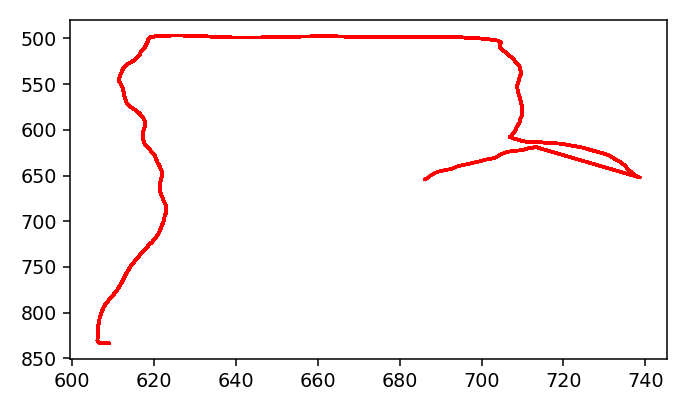

In [11]:
LiveDarwing(7554,5)

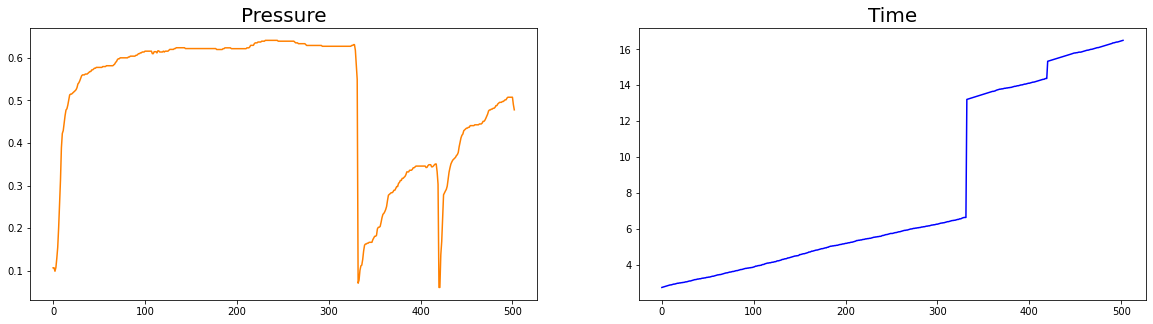

In [9]:
fig=plt.figure(figsize=(20,5))

ax= fig.add_subplot(1, 2, 1)
ax.plot(data.Pressure,"#FF8000")
ax.set_title("Pressure",fontdict={'fontsize': 20})

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(data.Time,c='b')
ax2.set_title("Time",fontdict={'fontsize': 20})

plt.show()

## *Hand lifts:*

The function counts hand lifts by using the Time column. <br>
When the child lifts his hand from the drawing,the time continues to run and in the next time he continues to draw, we will see  a "jump" in the time column. <br>We will count these "jumps".

In [29]:
def handLifts(data):
    hand_lifts = 0
    rolling_std = data.Time.rolling(window=14).std()

    for i in range(len(data.Time)-1):
        if (data.Time[i+1] > data.Time[i] + rolling_std[i]):
            hand_lifts +=1
    print("Number of hand lifts: " + str(hand_lifts))

In [31]:
handLifts(data)

Number of hand lifts: 2


## *Number of lines:*

This function should count the number of lines in each drawing.We thought of several ways to solve this task.<br>
The two ways that seemed most logical to us were:<br>

* Calculate the slope between the coordinates and when there is a drastic change in the slope define it as a line.
* Calculate the angle between the Coordinates, when the angle is far from 0, 180 or 360 we will define it as a line. <br>

Both ways do not work perfectly but are the best ways we could think of.<br>
After many attempts we found that the best way is to calculate angles.

In [12]:
def calculateAngle(X1,X0,Y1,Y0):
    deltaX = (X1 - X0)
    deltaY = (Y1 - Y0)
    rads = math.atan2(deltaY,deltaX)*(180/math.pi)
    if rads < 0 :
           rads +=360
    return rads

In [23]:
def numOfLines(data):
    indexes = [*range(0,len(data),int(len(data)/10))]
    angels = []
    lines_indexes =  [] #index where lines starts and end  
    numOfLines = 0
    for i in range(len(indexes)-1):
        angels.append(calculateAngle(data.X[i+1],data.X[i],data.Y[i+1],data.Y[i]))

    for i in range(len(angels)-1):
        if (0 <= angels[i] < 5) | (340 < angels[i] <= 360) | (170 < angels[i] <= 200) :
            continue
        else:
            numOfLines += 1
            lines_indexes.append(indexes[i])
    if (0 not in lines_indexes):
        lines_indexes.insert(0,0)

    print("Number of lines: " + str(numOfLines))
    return lines_indexes

In [24]:
numOfLines(data)

Number of lines: 5


[0, 100, 150, 300, 350, 400]

### *Line length and average pressure:*

##### From counting the number of lines in the drawing, we get a list of indexes. Every two numbers are the start and end of a line in the drawing.

Using the indexes, we calculate the length of each line and the average pressure applied to it

In [25]:

def lenAndPressure(index_list):
    frame = pd.DataFrame(index=['Length','Average Pressure'])
    
    for i in range(len(index_list)-1):
        
        first = (data.X[index_list[i]],data.Y[index_list[i]])
        last = (data.X[index_list[i+1]],data.Y[index_list[i+1]])
        length = math.dist(first,last)
        pressure = data.Pressure[index_list[i]:index_list[i+1]].mean()
        
        frame.insert(i,"Line "+str(i+1), [length,pressure])
        
    return frame

In [26]:
index_list = numOfLines(data)
lenAndPressure(index_list)

Number of lines: 5


,Line 1,Line 2,Line 3,Line 4,Line 5
Length,239.902558,83.469223,102.311204,56.478017,31.391349
Average Pressure,0.529783,0.618207,0.629252,0.450685,0.287138


## *Open or closed shape:*

Only relevant for some of the drawings.

(3,4,8,11,13,16,17,19,20,21)

In this function we used the image and not the CSV file. <br> 
We assumed that the coordinate (0,0) will not be part of the drawing (it would be white). <br>
We colored the drawing in yellow from the coordinate (0,0), if the shape is open then except for the line of the drawing, the whole image will colored yellow.<br> If the shape is closed then the area inside the drawing will remain white. <br>
(if we find a white coordinate (255,255,255) we will conclude that the shape is closed.)

In [5]:
def openOrClose(folder, img_num):
    img = Image.open(r'train/'+str(folder)+'/SimpleTest/'+str(img_num)+'.PNG')
    img = img.convert("RGB")
    img = img.crop((0,220,1360,885))
    target_pixel = (0,0) #Corner of the image
    target_color = (255,255,0) #Yellow
    ImageDraw.floodfill(img,target_pixel,target_color)
    im = asarray(img)
    fig = plt.figure(figsize=(8, 5))  
    plt.imshow(img)
    
    count =0 
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):
            if ((im[i][j] == [255,255,255]).all() == True):
                count+=1
    if count == 0:
        print ("Open Shape")
    else: 
        print ("Close Shape")

Close Shape


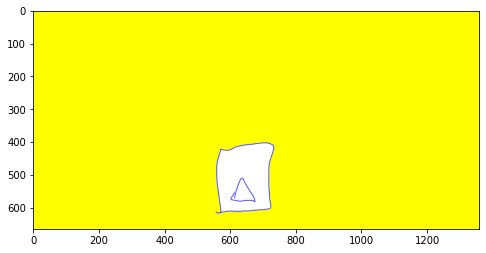

In [47]:
openOrClose(7558, 8)

# More examples:

Open Shape
Close Shape
Close Shape
Close Shape


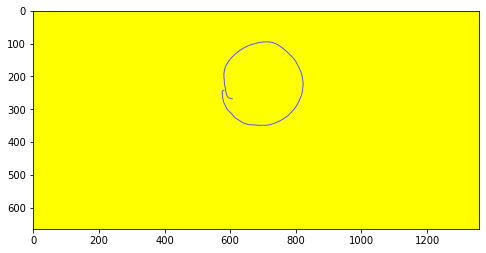

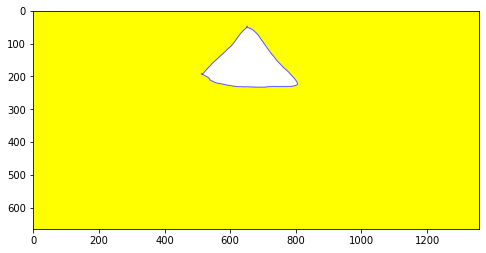

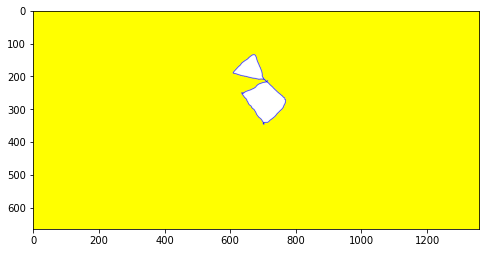

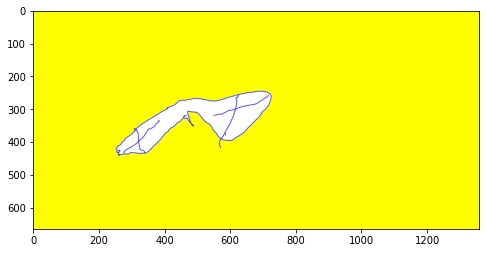

In [8]:
openOrClose(7570, 3)
openOrClose(7569, 4)
openOrClose(7574, 11)
openOrClose(7556, 21)